In [ ]:
import numpy as np
from sklearn import preprocessing
import pandas as pd
import plotly.offline as py
py.init_notebook_mode(connected=True)
import seaborn as sns
from scipy.stats import randint as sp_randint
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score,classification_report)
from imblearn.over_sampling import SMOTE
import warnings;warnings.filterwarnings('ignore')
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier
import statsmodels.api as sm
import plotly.graph_objs as go
import plotly.offline as py
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import NearMiss

In [ ]:
def draw_from_dict(dicdata,RANGE, heng=0):
    by_value = sorted(dicdata.items(),key = lambda item:item[1],reverse=True)
    x = []
    y = []
    for d in by_value:
        x.append(d[0])
        y.append(d[1])
    if heng == 0:
        plt.bar(x[0:RANGE], y[0:RANGE])
        plt.show()
        return
    elif heng == 1:
        plt.barh(x[0:RANGE], y[0:RANGE])
        plt.show()
        return
    else:
        return "Invalid"


In [ ]:
def get_accuracy(y_true,y_pred):
    return sum(y_true==y_pred)/len(y_true)

# Data Preparation

In [ ]:
#import data
df = pd.read_csv('NCDB_2014.csv',na_values=['NN','UU','XX','QQ','N','U','X','Q','NNNN','UUUU','XXXX'])

In [ ]:
df.shape

(297612, 22)

In [ ]:
df.isnull().sum()

C_YEAR        0
C_MNTH       24
C_WDAY       24
C_HOUR     2042
C_SEV         0
C_VEHS       26
C_CONF    25691
C_RCFG    28139
C_WTHR     4307
C_RSUR    12081
C_RALN    17958
C_TRAF    19316
V_ID          5
V_TYPE    15936
V_YEAR    29777
P_ID        631
P_SEX     18921
P_AGE     22578
P_PSN     10955
P_ISEV    20504
P_SAFE    63207
P_USER    14267
dtype: int64

In [ ]:
df.dtypes

C_YEAR      int64
C_MNTH    float64
C_WDAY    float64
C_HOUR    float64
C_SEV       int64
C_VEHS    float64
C_CONF    float64
C_RCFG    float64
C_WTHR    float64
C_RSUR    float64
C_RALN    float64
C_TRAF    float64
V_ID      float64
V_TYPE    float64
V_YEAR    float64
P_ID      float64
P_SEX      object
P_AGE     float64
P_PSN     float64
P_ISEV    float64
P_SAFE    float64
P_USER    float64
dtype: object

In [ ]:
#Drop NAs
df = df.dropna()

In [ ]:
df.shape

(166317, 22)

In [ ]:
#Drop columns
df = df.drop(['C_YEAR','V_ID','P_ID'], axis=1)

In [ ]:
#change viechle year to viechle age
#df["V_AGE"] = df["V_YEAR"].apply(lambda x: 2015-int(x) if x != 'NNNN' else x)
df["V_AGE"] = 2015-df["V_YEAR"]
df = df.drop(['V_YEAR'], axis=1)

In [ ]:
#change fatality column to 0/1
# Define a dictionary for the target mapping
target_map = {3:1,1:0,2:0}

# Use the pandas apply method to numerically encode our fatality target variable
df["P_ISEV"] = df["P_ISEV"].apply(lambda x: target_map[x])

# Define a dictionary for the target mapping
target_map = {1:1,2:0}

# Use the pandas apply method to numerically encode our fatality target variable
df["C_SEV"] = df["C_SEV"].apply(lambda x: target_map[x])

# Define a dictionary for the target mapping
target_map = {'F':0,'M':1}

# Use the pandas apply method to numerically encode our fatality target variable
df["P_SEX"] = df["P_SEX"].apply(lambda x: target_map[x])


In [ ]:
df.shape

(166317, 19)

In [ ]:
len(df[(df['C_SEV']==1)])

2261

In [ ]:
#drop outliners

def drop_outlinrs(df,field_name):
    iqr = 1.5*(np.percentile(df[field_name],75)-np.percentile(df[field_name],25))
    df.drop(df[df[field_name]>(iqr+np.percentile(df[field_name],75))].index,inplace=True)
    df.drop(df[df[field_name]<(np.percentile(df[field_name],25)-iqr)].index,inplace=True)

continuous = ['P_AGE','V_AGE']
for i in continuous:
    drop_outlinrs(df,i)

In [ ]:
df.shape

(163705, 19)

In [ ]:
len(df[(df['C_SEV']==1)])

2209

In [ ]:
df.dtypes

C_MNTH    float64
C_WDAY    float64
C_HOUR    float64
C_SEV       int64
C_VEHS    float64
C_CONF    float64
C_RCFG    float64
C_WTHR    float64
C_RSUR    float64
C_RALN    float64
C_TRAF    float64
V_TYPE    float64
P_SEX       int64
P_AGE     float64
P_PSN     float64
P_ISEV      int64
P_SAFE    float64
P_USER    float64
V_AGE     float64
dtype: object

# Data Preprocessing

In [ ]:
df1 = df.drop('P_ISEV',axis=1).copy()

In [ ]:
df1

,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_TYPE,P_SEX,P_AGE,P_PSN,P_SAFE,P_USER,V_AGE
29,1.0,1.0,22.0,0,1.0,3.0,3.0,5.0,5.0,5.0,18.0,1.0,1,19.0,11.0,2.0,1.0,7.0
30,1.0,1.0,19.0,0,2.0,41.0,3.0,1.0,3.0,1.0,18.0,1.0,0,19.0,11.0,2.0,1.0,8.0
31,1.0,1.0,19.0,0,2.0,41.0,3.0,1.0,3.0,1.0,18.0,1.0,1,22.0,11.0,2.0,1.0,9.0
32,1.0,1.0,10.0,0,3.0,35.0,2.0,2.0,2.0,1.0,3.0,1.0,1,33.0,11.0,2.0,1.0,1.0
33,1.0,1.0,10.0,0,3.0,35.0,2.0,2.0,2.0,1.0,3.0,1.0,0,33.0,13.0,2.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297583,12.0,7.0,14.0,0,2.0,41.0,1.0,1.0,5.0,1.0,18.0,5.0,1,44.0,11.0,2.0,1.0,7.0
297584,12.0,7.0,14.0,0,2.0,41.0,1.0,1.0,5.0,1.0,18.0,5.0,1,34.0,13.0,2.0,2.0,7.0
297585,12.0,7.0,19.0,0,1.0,3.0,1.0,1.0,3.0,4.0,18.0,1.0,0,35.0,11.0,2.0,1.0,14.0
297586,12.0,7.0,19.0,0,1.0,3.0,1.0,1.0,3.0,4.0,18.0,1.0,1,26.0,13.0,2.0,2.0,14.0


In [ ]:
df1.dtypes

C_MNTH    float64
C_WDAY    float64
C_HOUR    float64
C_SEV       int64
C_VEHS    float64
C_CONF    float64
C_RCFG    float64
C_WTHR    float64
C_RSUR    float64
C_RALN    float64
C_TRAF    float64
V_TYPE    float64
P_SEX       int64
P_AGE     float64
P_PSN     float64
P_SAFE    float64
P_USER    float64
V_AGE     float64
dtype: object

In [ ]:
numerical = ['C_VEHS','V_AGE','P_AGE','C_SEV']
categorical = df1.drop(numerical,axis=1).columns
categorical

Index(['C_MNTH', 'C_WDAY', 'C_HOUR', 'C_CONF', 'C_RCFG', 'C_WTHR', 'C_RSUR',
       'C_RALN', 'C_TRAF', 'V_TYPE', 'P_SEX', 'P_PSN', 'P_SAFE', 'P_USER'],
      dtype='object')

In [ ]:
#df1[numerical]

In [ ]:
for i in categorical:
    df1 = df1.astype({i: 'object'})

#create dummy variables for categorical data
df1_dis = df1[categorical]
df1_dis = pd.get_dummies(df1_dis)

#combine categorical and numerical columns
df1_total = pd.concat([df1_dis, df1[numerical]], axis=1)

In [ ]:
df1_total.shape

(163705, 150)

In [ ]:
df1_total

,C_MNTH_1.0,C_MNTH_2.0,C_MNTH_3.0,C_MNTH_4.0,C_MNTH_5.0,C_MNTH_6.0,C_MNTH_7.0,C_MNTH_8.0,C_MNTH_9.0,C_MNTH_10.0,C_MNTH_11.0,C_MNTH_12.0,C_WDAY_1.0,C_WDAY_2.0,C_WDAY_3.0,C_WDAY_4.0,C_WDAY_5.0,C_WDAY_6.0,C_WDAY_7.0,C_HOUR_0.0,C_HOUR_1.0,C_HOUR_2.0,C_HOUR_3.0,C_HOUR_4.0,C_HOUR_5.0,C_HOUR_6.0,C_HOUR_7.0,C_HOUR_8.0,C_HOUR_9.0,C_HOUR_10.0,C_HOUR_11.0,C_HOUR_12.0,C_HOUR_13.0,C_HOUR_14.0,C_HOUR_15.0,C_HOUR_16.0,C_HOUR_17.0,C_HOUR_18.0,C_HOUR_19.0,C_HOUR_20.0,...,V_TYPE_1.0,V_TYPE_5.0,V_TYPE_6.0,V_TYPE_7.0,V_TYPE_8.0,V_TYPE_9.0,V_TYPE_10.0,V_TYPE_11.0,V_TYPE_14.0,V_TYPE_17.0,V_TYPE_18.0,V_TYPE_21.0,V_TYPE_23.0,P_SEX_0,P_SEX_1,P_PSN_11.0,P_PSN_12.0,P_PSN_13.0,P_PSN_21.0,P_PSN_22.0,P_PSN_23.0,P_PSN_31.0,P_PSN_32.0,P_PSN_33.0,P_PSN_96.0,P_PSN_97.0,P_PSN_98.0,P_SAFE_1.0,P_SAFE_2.0,P_SAFE_9.0,P_SAFE_12.0,P_SAFE_13.0,P_USER_1.0,P_USER_2.0,P_USER_4.0,P_USER_5.0,C_VEHS,V_AGE,P_AGE,C_SEV
29,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1.0,7.0,19.0,0
30,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,2.0,8.0,19.0,0
31,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,2.0,9.0,22.0,0
32,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,3.0,1.0,33.0,0
33,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,3.0,1.0,33.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297583,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,2.0,7.0,44.0,0
297584,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,2.0,7.0,34.0,0
297585,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1.0,14.0,35.0,0
297586,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1.0,14.0,26.0,0


In [ ]:
y,x = df1_total["C_SEV"].values,df1_total.loc[:, df1_total.columns.drop(['C_SEV'])].values
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

enn = EditedNearestNeighbours(random_state=0)
smote_x, smote_y = enn.fit_resample(x_train,y_train)

under = RandomUnderSampler(sampling_strategy=1,random_state=0)
smote_x, smote_y = under.fit_sample(smote_x, smote_y)

In [ ]:
df1_total.to_csv('df1_data.csv',index=False)

# Logistic Regression

In [ ]:
len(smote_x)

3444

In [ ]:
len(smote_y[smote_y==1])

1722

In [ ]:
LR1 = LR(random_state=0).fit(x_train, y_train)
print(LR1.score(x_train, y_train),LR1.score(x_test,y_test))

0.986782627286888 0.9851562261384808


In [ ]:
LR1 = LR(random_state=0).fit(smote_x, smote_y)
print(LR1.score(smote_x, smote_y),LR1.score(x_test,y_test))

0.771486643437863 0.7798173543874652


In [ ]:
LR_predictions = LR1.predict(x_test)
print("Accuracy score: {}".format(accuracy_score(y_test, LR_predictions)))
print("="*40)
print(classification_report(y_test, LR_predictions))

Accuracy score: 0.7798173543874652
              precision    recall  f1-score   support

           0       0.99      0.78      0.87     32254
           1       0.05      0.72      0.09       487

    accuracy                           0.78     32741
   macro avg       0.52      0.75      0.48     32741
weighted avg       0.98      0.78      0.86     32741



In [ ]:
conf_mat = confusion_matrix(y_test, LR_predictions)
print(conf_mat)

[[25179  7075]
 [  134   353]]


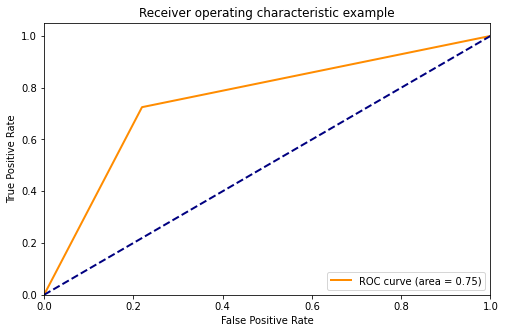

In [ ]:
fpr, tpr, threshold = roc_curve(y_test,LR_predictions)
roc_auc = auc(fpr, tpr)
lw = 2
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

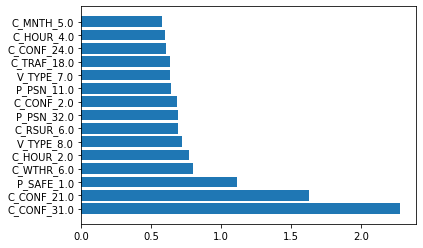

In [ ]:
x_columns = df1_total.drop(['C_SEV'],axis=1).columns

m = {}
for i in range(x_columns.shape[0]):
    m.setdefault(x_columns[i], 0)
    m[x_columns[i]] = abs(LR1.coef_[0,i])

sorted(m.items(), key=lambda x: x[1],reverse=False)
draw_from_dict(m,15,1)

### test 1

# Decision tree

In [ ]:
len(smote_x)

3444

In [ ]:
#Model 2: Decision Tree
#fit model, max tree
clf_dt = DecisionTreeClassifier(random_state=2020)
clf_dt = clf_dt.fit(smote_x, smote_y)

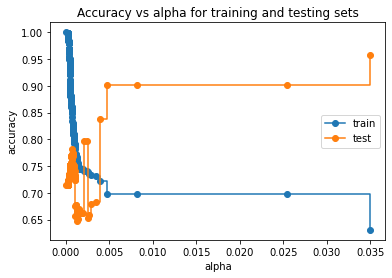

Highest validation accuracy: 0.9579


In [ ]:
#find ccp_alpha with highest validation accuracy
path = clf_dt.cost_complexity_pruning_path(smote_x, smote_y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities#ccp=cost complexity pruning
ccp_alphas = ccp_alphas[:-1]#omit the maximum value for alpha because it would prune all leaves

clf_dts = []
alpha_loop_values = []
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=2020, ccp_alpha=ccp_alpha)
    clf_dt.fit(smote_x, smote_y)
    clf_dts.append(clf_dt)
    for clf_dt in clf_dts:
        test_score = clf_dt.score(x_test, y_test) #scores=accuracy
    alpha_loop_values.append([ccp_alpha, test_score])

train_scores = [clf_dt.score(smote_x, smote_y) for clf_dt in clf_dts]#scores=accuracy
test_scores = [clf_dt.score(x_test, y_test) for clf_dt in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()
print('Highest validation accuracy: {:.4f}'.format(max(test_scores)))

In [ ]:
train_scores = [clf_dt.score(smote_x, smote_y) for clf_dt in clf_dts]#scores=accuracy
test_scores = [clf_dt.score(x_test, y_test) for clf_dt in clf_dts]

alpha_results = pd.DataFrame(alpha_loop_values,
                             columns=['alpha', 'val_accuracy'])
#print(alpha_results)

print(max(alpha_results['val_accuracy']))
pruned_ccp_alpha=alpha_results[(alpha_results['val_accuracy']==max(alpha_results['val_accuracy']))]['alpha']
pruned_ccp_alpha

0.9578510124919826


294    0.034955
Name: alpha, dtype: float64

0.0349551533686171
Decision Tree TestSet Accuracy: 95.79%


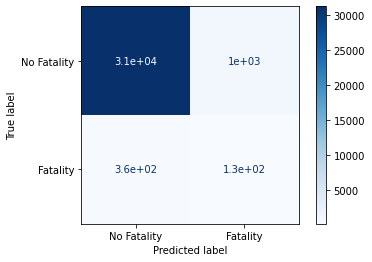

In [ ]:
#prune the tree
pruned_ccp_alpha=float(pruned_ccp_alpha.iloc[0])
print(pruned_ccp_alpha)

clf_dt_pruned = DecisionTreeClassifier(random_state=2020,
                                       ccp_alpha=pruned_ccp_alpha)
clf_dt_pruned = clf_dt_pruned.fit(smote_x, smote_y)

#use pruned tree model to predict on testset
y_pred_pruned = clf_dt_pruned.predict(x_test)

#check testset accuracy
plot_confusion_matrix(clf_dt_pruned,
                      x_test,
                      y_test,
                      display_labels=["No Fatality", "Fatality"],
                      cmap='Blues')

print("Decision Tree TestSet Accuracy: {0:.2f}%".format(get_accuracy(y_test, y_pred_pruned)*100))

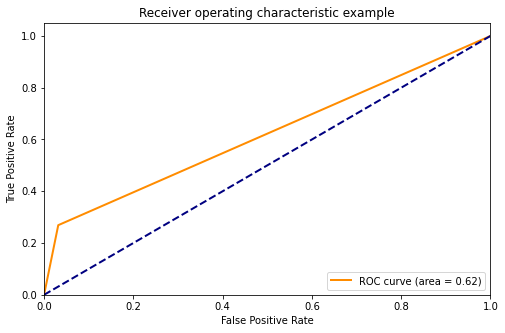

In [ ]:
fpr, tpr, threshold = roc_curve(y_test,y_pred_pruned)
roc_auc = auc(fpr, tpr)
lw = 2
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

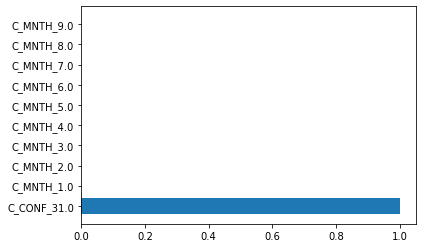

In [ ]:
x_columns = df1_total.drop(['C_SEV'],axis=1).columns

m = {}
for i in range(x_columns.shape[0]):
    m.setdefault(x_columns[i], 0)
    m[x_columns[i]] = clf_dt_pruned.feature_importances_[i]

sorted(m.items(), key=lambda x: x[1], reverse=True)
draw_from_dict(m,10,1)

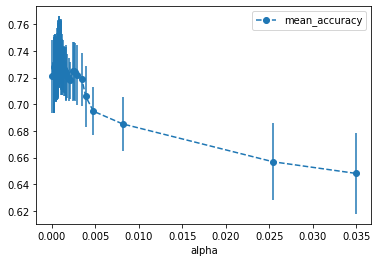

In [ ]:
#use cross-validation to find ideal_ccp_alpha
alpha_loop_values = []
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=2020, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, smote_x, smote_y, cv=10)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])

alpha_results = pd.DataFrame(alpha_loop_values,
                             columns=['alpha', 'mean_accuracy', 'std'])

alpha_results.plot(x='alpha',
                   y='mean_accuracy',
                   yerr='std',
                   marker='o',
                   linestyle='--')

In [ ]:
max(alpha_results['mean_accuracy'])

0.7418747893495112

In [ ]:
ideal_ccp_alpha=alpha_results[(alpha_results['mean_accuracy']==max(alpha_results['mean_accuracy']))]['alpha']
ideal_ccp_alpha

263    0.001014
Name: alpha, dtype: float64

In [ ]:
ideal_ccp_alpha=float(ideal_ccp_alpha)
ideal_ccp_alpha

0.001013620525815646

In [ ]:
#prune the tree with ideal_ccp_alpha
clf_dt_pruned = DecisionTreeClassifier(random_state=2020,
                                       ccp_alpha=ideal_ccp_alpha)

Decision Tree TrainSet Accuracy: 79.33%


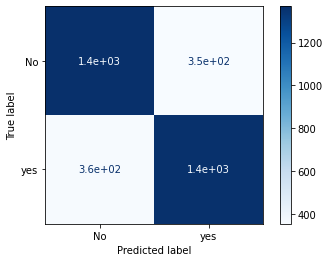

In [ ]:
clf_dt_pruned = clf_dt_pruned.fit(smote_x, smote_y)

#use model to predict on trainset
y_pred_pruned = clf_dt_pruned.predict(smote_x)

#check trainset accuracy
print("Decision Tree TrainSet Accuracy: {0:.2f}%".format(get_accuracy(smote_y, y_pred_pruned)*100))
plot_confusion_matrix(clf_dt_pruned,
                      smote_x,
                      smote_y,
                      display_labels=["No", "yes"],
                      cmap='Blues')

Decision Tree TestSet Accuracy: 74.17%


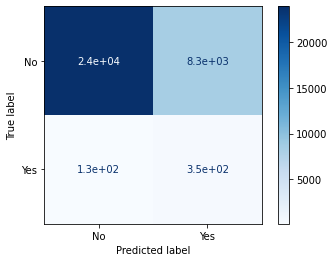

In [ ]:
#use model to predict on testset
y_pred_pruned = clf_dt_pruned.predict(x_test)

#check testset accuracy
print("Decision Tree TestSet Accuracy: {0:.2f}%".format(get_accuracy(y_test, y_pred_pruned)*100))
plot_confusion_matrix(clf_dt_pruned,
                      x_test,
                      y_test,
                      display_labels=["No", "Yes"],
                      cmap='Blues')

In [ ]:
LR_predictions = y_pred_pruned = clf_dt_pruned.predict(x_test)
print("Accuracy score: {}".format(accuracy_score(y_test, LR_predictions)))
print("="*40)
print(classification_report(y_test, LR_predictions))

Accuracy score: 0.7416694664182524
              precision    recall  f1-score   support

           0       0.99      0.74      0.85     32254
           1       0.04      0.73      0.08       487

    accuracy                           0.74     32741
   macro avg       0.52      0.73      0.46     32741
weighted avg       0.98      0.74      0.84     32741



In [ ]:
conf_mat = confusion_matrix(y_test, y_pred_pruned)
print(conf_mat)

[[23929  8325]
 [  133   354]]


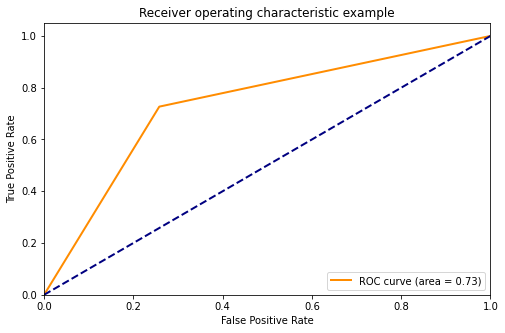

In [ ]:
fpr, tpr, threshold = roc_curve(y_test,y_pred_pruned)
roc_auc = auc(fpr, tpr)
lw = 2
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

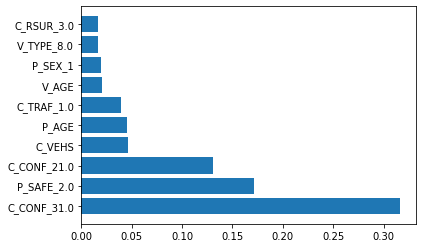

In [ ]:
x_columns = df1_total.drop(['C_SEV'],axis=1).columns

m = {}
for i in range(x_columns.shape[0]):
    m.setdefault(x_columns[i], 0)
    m[x_columns[i]] = clf_dt_pruned.feature_importances_[i]

sorted(m.items(), key=lambda x: x[1], reverse=True)
draw_from_dict(m,10,1)

# Random forest

In [ ]:
len(smote_x)

3444

In [ ]:
len(smote_y[smote_y==1])

1722

In [ ]:
forest = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
forest.fit(smote_x, smote_y)
forest_predictions = forest.predict(x_test)
print("Accuracy score: {}".format(accuracy_score(y_test, forest_predictions)))
print("="*40)
print(classification_report(y_test, forest_predictions))

Accuracy score: 0.8004642497174796
              precision    recall  f1-score   support

           0       1.00      0.80      0.89     32254
           1       0.06      0.82      0.11       487

    accuracy                           0.80     32741
   macro avg       0.53      0.81      0.50     32741
weighted avg       0.98      0.80      0.88     32741



In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, forest_predictions)
print(conf_mat)

[[25811  6443]
 [   90   397]]


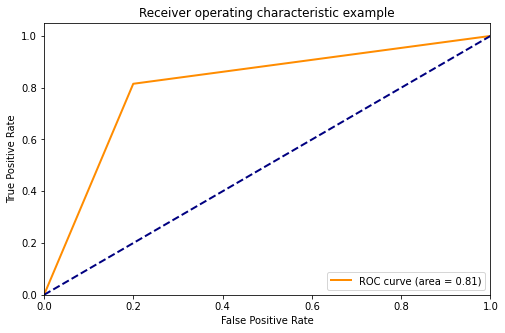

In [ ]:
fpr, tpr, threshold = roc_curve(y_test,forest_predictions)
roc_auc = auc(fpr, tpr)
lw = 2
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

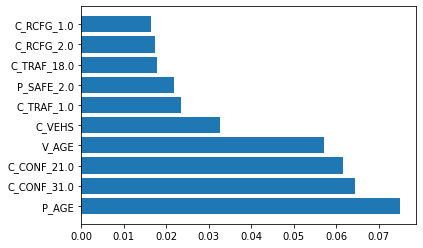

In [ ]:
x_columns = df1_total.drop(['C_SEV'],axis=1).columns

m = {}
for i in range(x_columns.shape[0]):
    m.setdefault(x_columns[i], 0)
    m[x_columns[i]] = forest.feature_importances_[i]

sorted(m.items(), key=lambda x: x[1], reverse=True)
draw_from_dict(m,10,1)

In [ ]:
params = {"max_depth": [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
          "max_features": ['auto', 'sqrt','log2'],
          "min_samples_split": [2, 5, 10, 15, 20, 30, 40, 50],
          "bootstrap": [True, False],
          "criterion": ["gini", "entropy"],
          "n_estimators":[100, 150, 200, 250, 300, 400, 500]}

forest = RandomForestClassifier(random_state = 0)
random_search=RandomizedSearchCV(forest,param_distributions=params,
                                 n_iter=5,scoring='accuracy',n_jobs=-1,cv=5,verbose=1,random_state = 0)
random_search.fit(smote_x, smote_y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   23.1s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
random_search.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_split': 2,
 'n_estimators': 250}

In [ ]:
forest_final = RandomForestClassifier(**random_search.best_params_,random_state = 0)
forest_final.fit(smote_x, smote_y)
forest_predictions = forest_final.predict(x_test)
print("Accuracy score: {}".format(accuracy_score(y_test, forest_predictions)))
print("="*40)
print(classification_report(y_test, forest_predictions))

Accuracy score: 0.8046180629791393
              precision    recall  f1-score   support

           0       1.00      0.80      0.89     32254
           1       0.06      0.83      0.11       487

    accuracy                           0.80     32741
   macro avg       0.53      0.82      0.50     32741
weighted avg       0.98      0.80      0.88     32741



In [ ]:
conf_mat = confusion_matrix(y_test, forest_predictions)
print(conf_mat)

[[25940  6314]
 [   83   404]]


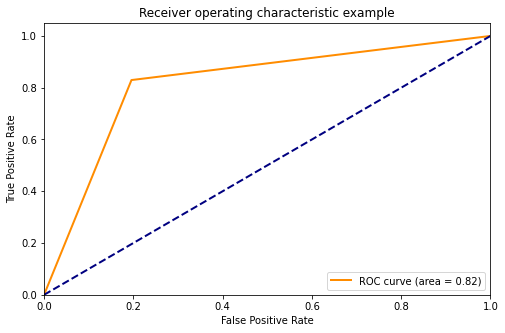

In [ ]:
fpr, tpr, threshold = roc_curve(y_test,forest_predictions)
roc_auc = auc(fpr, tpr)
lw = 2
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

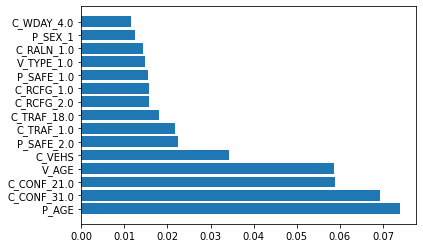

In [ ]:
x_columns = df1_total.drop(['C_SEV'],axis=1).columns
m = {}
for i in range(x_columns.shape[0]):
    m.setdefault(x_columns[i], 0)
    m[x_columns[i]] = forest_final.feature_importances_[i]

sorted(m.items(), key=lambda x: x[1], reverse=True)
draw_from_dict(m,15,1)

# XGBoost

### xgb

In [ ]:
bst = XGBClassifier(learning_rate =0.1,
  n_estimators=100,
  max_depth=5,
  min_child_weight=1,
  gamma=0,
  subsample=0.8,
  colsample_bytree=0.8,
  objective= 'binary:logistic',
  nthread=4,
  scale_pos_weight=1,
  seed=0)

bst = bst.fit(smote_x, smote_y)
train_preds = bst.predict(smote_x)
train_predictions = [round(value) for value in train_preds]
train_accuracy = accuracy_score(smote_y,train_predictions)

print("Train Accuracy:%.2f%%"%(train_accuracy*100.0))


preds = bst.predict(x_test)
predictions = [round(value) for value in preds]
test_accuracy = accuracy_score(y_test,predictions)

print("Test Accuracy:%.2f%%"%(test_accuracy*100.0))

Train Accuracy:85.37%
Test Accuracy:79.70%


In [ ]:
print("Accuracy score: {}".format(accuracy_score(y_test, predictions)))
print("="*40)
print(classification_report(y_test, predictions))

Accuracy score: 0.7969823768363825
              precision    recall  f1-score   support

           0       1.00      0.80      0.89     32254
           1       0.05      0.74      0.10       487

    accuracy                           0.80     32741
   macro avg       0.52      0.77      0.49     32741
weighted avg       0.98      0.80      0.87     32741



In [ ]:
conf_mat = confusion_matrix(y_test, predictions)
print(conf_mat)

[[25732  6522]
 [  125   362]]


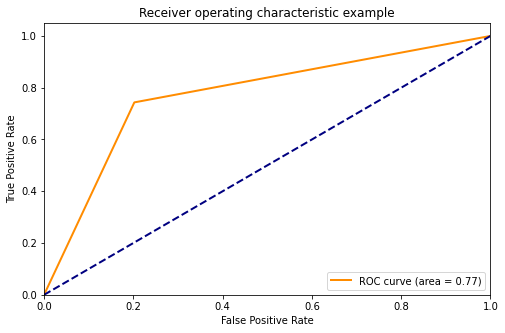

In [ ]:
fpr, tpr, threshold = roc_curve(y_test,predictions)
roc_auc = auc(fpr, tpr)
lw = 2
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

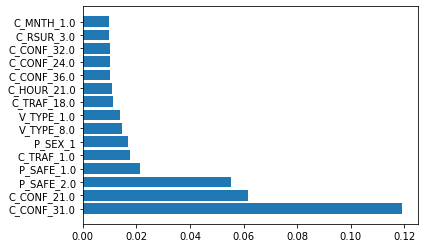

In [ ]:
x_columns = df1_total.drop(['C_SEV'],axis=1).columns

m = {}
for i in range(x_columns.shape[0]):
    m.setdefault(x_columns[i], 0)
    m[x_columns[i]] = bst.feature_importances_[i]

sorted(m.items(), key=lambda x: x[1], reverse=True)
draw_from_dict(m,15,1)

## test 1

In [ ]:
params_test1 = {'n_estimators': [100,150,200,250,300],
                "max_depth": [5, 10, 20, 30, None]
                }
other_params = {'learning_rate': 0.1,
                #'max_depth': 10,
                'min_child_weight': 1,
                'seed': 0,
                'subsample': 0.6, 'colsample_bytree': 0.6, 'gamma': 0, 'objective': 'binary:logistic',
                'nthread':4,'scale_pos_weight':1,
                'reg_alpha': 0, 'reg_lambda': 1}

bst = XGBClassifier(**other_params)
optimized_XGB= GridSearchCV(estimator=bst, param_grid=params_test1, scoring='accuracy', cv=5, verbose=2, n_jobs=4)
optimized_XGB.fit(smote_x, smote_y)
evalute_result = optimized_XGB.best_score_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  8.1min finished


In [ ]:
optimized_XGB.best_params_

{'max_depth': 20, 'n_estimators': 100}

In [ ]:
conf_mat = confusion_matrix(y_test, predictions)
print(conf_mat)

[[25732  6522]
 [  125   362]]


In [ ]:
bst_final = XGBClassifier(**optimized_XGB.best_params_)
bst_final.fit(smote_x, smote_y)
bst_predictions = bst_final.predict(x_test)
print("Accuracy score: {}".format(accuracy_score(y_test, bst_predictions)))
print("="*40)
print(classification_report(y_test, bst_predictions))

Accuracy score: 0.7956079533306863
              precision    recall  f1-score   support

           0       1.00      0.80      0.88     32254
           1       0.06      0.81      0.11       487

    accuracy                           0.80     32741
   macro avg       0.53      0.80      0.49     32741
weighted avg       0.98      0.80      0.87     32741



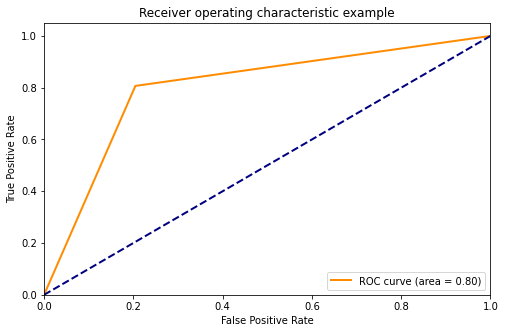

In [ ]:
fpr, tpr, threshold = roc_curve(y_test,bst_predictions)
roc_auc = auc(fpr, tpr)
lw = 2
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

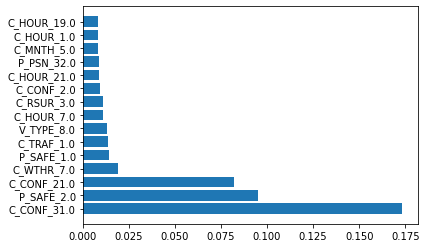

In [ ]:
x_columns = df1_total.drop(['C_SEV'],axis=1).columns

m = {}
for i in range(x_columns.shape[0]):
    m.setdefault(x_columns[i], 0)
    m[x_columns[i]] = bst_final.feature_importances_[i]

sorted(m.items(), key=lambda x: x[1], reverse=True)
draw_from_dict(m,15,1)

In [ ]:
bst_predictions = bst_final.predict(smote_x)
print("Accuracy score: {}".format(accuracy_score(smote_y, bst_predictions)))
print("="*40)

Accuracy score: 1.0


## test 2

In [ ]:
params_test1 = {'max_depth': [5,10,15,20]}
other_params = {'n_estimators': 200, 'learning_rate': 0.1, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}

bst = XGBClassifier(**other_params)
optimized_XGB= GridSearchCV(estimator=bst, param_grid=params_test1, scoring='roc_auc', cv=5, verbose=1, n_jobs=4)
optimized_XGB.fit(smote_x, smote_y)
evalute_result = optimized_XGB.best_score_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  1.7min finished


In [ ]:
optimized_XGB.best_params_

{'max_depth': 10}

In [ ]:
conf_mat = confusion_matrix(y_test, predictions)
print(conf_mat)

[[25732  6522]
 [  125   362]]


In [ ]:
bst_final = XGBClassifier(**optimized_XGB.best_params_)
bst_final.fit(smote_x, smote_y)
bst_predictions = bst_final.predict(x_test)
print("Accuracy score: {}".format(accuracy_score(y_test, bst_predictions)))
print("="*40)
print(classification_report(y_test, bst_predictions))

Accuracy score: 0.7920344522158761
              precision    recall  f1-score   support

           0       1.00      0.79      0.88     32254
           1       0.05      0.80      0.10       487

    accuracy                           0.79     32741
   macro avg       0.53      0.80      0.49     32741
weighted avg       0.98      0.79      0.87     32741



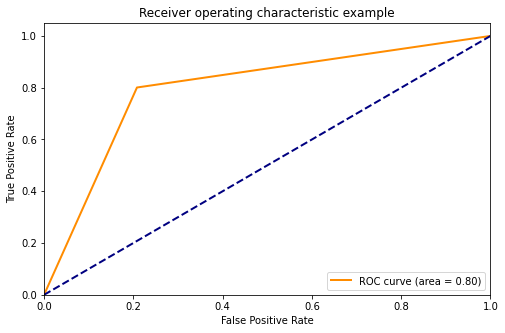

In [ ]:
fpr, tpr, threshold = roc_curve(y_test,bst_predictions)
roc_auc = auc(fpr, tpr)
lw = 2
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

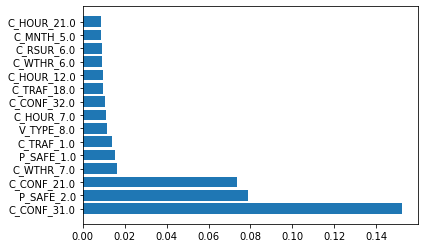

In [ ]:
x_columns = df1_total.drop(['C_SEV'],axis=1).columns

m = {}
for i in range(x_columns.shape[0]):
    m.setdefault(x_columns[i], 0)
    m[x_columns[i]] = bst_final.feature_importances_[i]

sorted(m.items(), key=lambda x: x[1], reverse=True)
draw_from_dict(m,15,1)